## Import Libraries

In [19]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Performance metrics calculation support library
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error

# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt


## Data preprocessing

### Read data

In [20]:
df = pd.read_csv('../../../../Dataset/INTC.csv')
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


### Reset index

In [21]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [22]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [23]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [24]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [25]:
# Install library pmdarima
!pip install pmdarima

### Training process

In [26]:
# Preparing training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

In [27]:
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2766.810, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2726.691, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2762.919, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2755.852, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2728.654, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2768.306, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2769.588, Time=0.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2768.573, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2762.956, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2766.680, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2771.533, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2757.786, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2770.254, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-2770.521, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0

In [28]:
# Fit the model
model.fit(y_train)

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### Validate Processing

In [29]:
# Preparing validation data
x_val = np.array(range(train_size, train_size + val_size)).reshape(-1, 1)
y_val = np.array(val_data).reshape(-1)
y_pred_val = model.predict(n_periods = len(y_val))

### Testing Processing

In [30]:
x_test = np.array(range(test_size, train_size + val_size + test_size)).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred = model.predict(n_periods=len(y_test))

### Evaluate Model

In [31]:
# Evaluate the accuracy of validation
y_val = scaler.inverse_transform(np.array([y_val]).reshape(-1, 1))
y_pred_val = scaler.inverse_transform(np.array([y_pred_val]).reshape(-1, 1))

val_mape = mean_absolute_percentage_error(y_val, y_pred_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val, y_pred_val)

print(f"MAPE on Validate set: ", val_mape)
print(f"RMSE on Validate set: ", val_rmse)
print(f"MSLE on Validate set: ", val_msle)

MAPE on Validate set:  0.14197407806200776
RMSE on Validate set:  7.885341633453508
MSLE on Validate set:  0.02664450731827805


In [32]:
# Evaluate the accuracy of test
y_test = scaler.inverse_transform(np.array([y_test]).reshape(-1, 1))
y_pred = scaler.inverse_transform(np.array([y_pred]).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.8326522637282762
RMSE on Test dataset:  24.438646059024055
MSLE on Test dataset:  0.3526980256993238


## Predicting the next 30 days

### Preparing the prediction data

In [33]:
# The process of creating index predict next 30 days
last_index =  df_Close.index[-1]

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

### Prediction process

In [34]:
# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))
y_next_30_days = scaler.inverse_transform(np.array([y_next_30_days]).reshape(-1, 1))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[53.95831107 54.00798543 54.00798543 54.00798543 54.00798543 54.00798543
 54.00798543 54.00798543 54.00798543 54.00798543 54.00798543 54.00798543
 54.00798543 54.00798543 54.00798543 54.00798543 54.00798543 54.00798543
 54.00798543 54.00798543 54.00798543 54.00798543 54.00798543 54.00798543
 54.00798543 54.00798543 54.00798543 54.00798543 54.00798543 54.00798543]


### Preparing the forecast date index


In [35]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Visualization

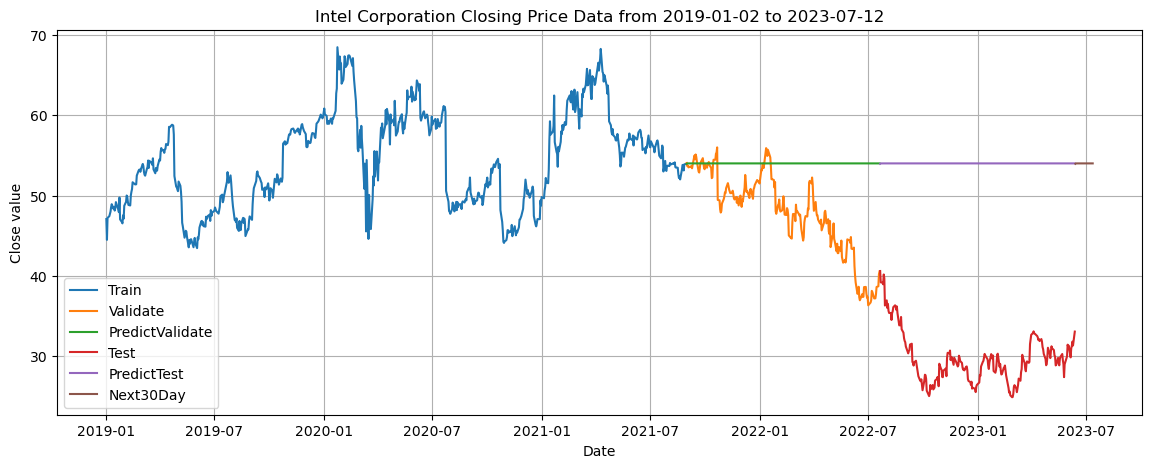

In [36]:
# Drawing
plt.figure(figsize=(14, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(np.array([y_train]).reshape(-1, 1)))

plt.plot(df.index[train_size : train_size + val_size], y_val)

plt.plot(df.index[train_size : train_size + val_size], y_pred_val)

plt.plot(df.index[train_size + val_size :], y_test)

plt.plot(df.index[train_size + val_size :], y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Day'])

plt.grid()
plt.title(f"Intel Corporation Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('../Image/ARIMA_622_INTC.png')
plt.show()